# Bericht und Code zum Beleg Maschinelles Lernen


Name: Hong Quan, Nguyen
Matrikelnummer: 566212

Name: Chanel, Lipski
Matrikelnummer:557964

### Gliederung

* [Code](#Code)
* [Bericht](#Bericht)
 * [Bewertung der Daten](#Bewertung-der-Daten)
 * [Datenteilung](#Datenteilung)
 * [Text Feature Extraction](#Text-Feature-Extraction)
 * [Exkurs: Einsatz eines Stemmers](#Exkurs:-Einsatz-eines-Stemmers)
 * [Untersuchung der Stemmer](#Untersuchung-der-Stemmer)
 * [Implementierung des Feature-Spaltenselektor](#Implementierung-des-Feature-Spaltenselektor)
 * [Klassifikatoren](#Klassifikatoren)
 * [Evaluation](#Evaluation)
 * [ROC-Kurve](#ROC-Kurve)
 * [ROC-Kurve Intepretation](#ROC-Kurve-Intepretation)
 * [Feature Selection](#Feature-Selection)
 * [Mutual Information](#Mutual-Information)
 * [Tunning Parameter: Grid Search / Random Search](#Tunning-Parameter:-Grid-Search-/-Random-Search)
 
 
 * [Evaluation auf der Testmenge](#Evaluation-auf-der-Testmenge)
 * [Exkurs - Naive Bayes Model](#Exkurs---Naive-Bayes-Model)
  * [Naive Bayes Evaluation](#Naive-Bayes-Evaluation)
 * [Literaturverzeichnis](#Literaturverzeichnis)

In [2]:
#Importiert alles
import pandas as pd
import numpy as np
import sklearn
import nltk


from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, model_selection, svm


from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

# Plot Bibliothek, für ROC Histogramm
import seaborn as sns

In [2]:
'''
class Tokenizer:
    def fit(self,*_):
        return self
    def transform(self,x,y=None,**fit_params):
        tokenized=df.apply(lambda row: nltk.word_tokenize(row['title']+" "+row['text'], language='english'), axis=1)
        stop_words = set(stopwords.words('english')) 
        return x.apply(lambda row: [w for w in row['title'] if not w in stop_words], axis=1)
'''

In [4]:
# Die Datei sollte in dem selben Verzeichnis liegen, wie das notebook
# bitte den Pfad NICHT ändern, sodass es bei mir gleich durchläuft!
df = pd.read_csv('data_beleg.csv', encoding='utf-8')

# The column "label" is the target variable y which should be predicted

# Bericht

## Bewertung der Daten


In [4]:
df

,Unnamed: 0,title,text,label
0,3250,Strawberry Pistachio Crumble A Spicy Perspective,When you re out in the berry patch drinking in...,1
1,4311,BBC News Study links Parkinson s disease to in...,13 November 2011 Last updated at 23 57 ET By N...,1
2,6544,Want to know the effect of a nuclear bomb on y...,By Damien Gayle UPDATED 13 12 EST 16 February ...,1
3,5328,Japanese Nail Art by NeverTooMuchGlitter by Ne...,Check out my featured work in the August Septe...,0
4,1402,How the New 5 Euro Bill is Made,A new 5 euro note will be circulating starting...,1
...,...,...,...,...
4646,2708,Halloween Dessert Recipe Chocolate Abyss hallo...,This delicious dish was created for the M M s ...,0
4647,6324,eat me delicious Cauliflower Gratin,Looking at this picture I m not sure if you ca...,1
4648,2777,Unusual Medical Uses For Duct Tape,Duct Tape is possibly the most incredible inve...,1
4649,1508,Reporter Flips Out from That Happened reporter...,"reporter flips out, news blooper, bug, south,...",0


### Datenteilung

In [5]:
# Insgesamt sind 4650 Datensätze vorhanden
# Wir splitten die Datensätze in zwei Teile
# 2/3 der Daten werden als Traningsdaten verwendet
# der Rest wird für die Evaluation verwendet
splitIndex = int(2*len(df)/3)

df_train = df.loc[:splitIndex,:]
df_test = df.loc[splitIndex:,:] 

df_train

,Unnamed: 0,title,text,label
0,3250,Strawberry Pistachio Crumble A Spicy Perspective,When you re out in the berry patch drinking in...,1
1,4311,BBC News Study links Parkinson s disease to in...,13 November 2011 Last updated at 23 57 ET By N...,1
2,6544,Want to know the effect of a nuclear bomb on y...,By Damien Gayle UPDATED 13 12 EST 16 February ...,1
3,5328,Japanese Nail Art by NeverTooMuchGlitter by Ne...,Check out my featured work in the August Septe...,0
4,1402,How the New 5 Euro Bill is Made,A new 5 euro note will be circulating starting...,1
...,...,...,...,...
3096,4522,How Much is Inside Kalles Kaviar,How Much is Inside Kalles Kaviar Kalles Kaviar...,0
3097,5771,5 Reasons Why It s Okay to Like the Canadian F...,With the NFL lockout looming overheard like a ...,0
3098,3695,Fashion Alices Photography Haute Couture,Fashion Alices Photography Haute Couture Xah L...,0
3099,6273,Plush Palate Quote of the Week,Blog ArchiveFebruary 16 January 16 December 25...,0


In [6]:
df_test

,Unnamed: 0,title,text,label
3100,6538,Loaded Roasted Potatoes and Chicken,I don t generally take pictures the first time...,1
3101,4004,Homemade Bruschetta Recipes for Kids | recipes...,Homemade Bruschetta Recipes for Kids Parents C...,1
3102,1888,Maxim Amazing Celebrity News Videos Gossip and...,She may not have finished first on the tennis ...,0
3103,222,Top 8 Awesome Apps For iPhone,Hello iPhone fans We have come with popular iP...,0
3104,4832,Stress Management Stress And Alcohol stress ma...,Monday April 30 2007 12 35 AM GeneralPosted by...,1
...,...,...,...,...
4646,2708,Halloween Dessert Recipe Chocolate Abyss hallo...,This delicious dish was created for the M M s ...,0
4647,6324,eat me delicious Cauliflower Gratin,Looking at this picture I m not sure if you ca...,1
4648,2777,Unusual Medical Uses For Duct Tape,Duct Tape is possibly the most incredible inve...,1
4649,1508,Reporter Flips Out from That Happened reporter...,"reporter flips out, news blooper, bug, south,...",0


## Text Feature Extraction
Tokenizer -> Text Vektorisierung mit Bag of Words + TF-IDF (Erklärung und Exkurs mit Skicit learn)
* Bag of Words (BoW): Ist eine einfache Repräsentation, die in "Natural Language Processing" und "Information Retrieval" verwendet wird. Ein "Bag-of-Words"-Modell, ist eine Möglichkeit, Merkmale aus Text zu extrahieren, um sie bei der Modellierung zu verwenden, z. B. mit Algorithmen des maschinellen Lernens. (1)


In diesem Model werden Texte in einer Menge von Worten repräsentiert mit ihrer Anzahl der Häufigkeit. Dabei wird die Grammatik und die Reihenfolge außer Acht gelassen.

zum Beispiel wird "How the New 5 Euro Bill is Made, A new 5 euro note will be circulating starting", wie folgt dargestellt: 
    
    {"how":1, "the":1, "new": 2, "5": 2, "euro": 2, "bill": 1, "is": 1, "made": 1, "a": 1, "note": 1, "will": 1, "be": 1, "circulating": 1, "starting": 1}
    
    
* Das BoW Model hat auch einen Nachteil beim Text Klassifikator. Die Häufigkeit der Worte ist nicht ausreichend für die Klassifikation. Worte mit wenig Informationsgehalt können beim Traning des Klassifikators das Ergebnis negativ beeinflussen. Dieser Nachteil lässt sich in der Praxis meist mit dem Tf-idf-Algorithmus ausgleichen, indem Worte anhand deren Häufigkeit in einem Dokument und der Häufigkeit in einem Satz von Dokumenten gewichtet werden. Wenn ein Wort häufig in einem Dokument erscheint, jedoch nicht in anderen Dokumenten, hat das Wort eine größere Gewichtung. Wenn ein Wort häufig in den Dokumenten verwendet wird, ist das möglicherweise irrelevant. Ziel des Algorithmus ist, die häufig vorkommenden Worte wie zum Beispiel "der", "die", "das" zu normalisieren, weil sie nicht relevant für das Training sind. (2)


* Die Kombination von BoW und Tf-idf lässt sich sehr einfach mit Scikit-learn implementieren. Die Klasse "CountVectorizer" und "TfidfTransformer" vom Paket "sklearn.feature_extraction.text" können in der Pipeline verwendet werden. 

    Nachfolgend ein Beispiel, wie die Pipeline aussehen könnte:

In [7]:
pipe = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer())
                ]).fit(df["title"])

# Das Ergebnis nach "CountVectorizer" ist eine zweidimensionale Matrix
#          | feature1  | feature2  | ...
#  data1   | frequence | frequence | ...
#  data2   | frequence | frequence | ...
#  ...     |  ...      |  ...      | ...
print(pipe['vect'].transform(df["title"]).toarray())

print("** Anzahl von extrahierten features")
numberOfFeatures = len(pipe['vect'].get_feature_names())
print(numberOfFeatures)

print("** Liste von extrahierten Features")
print(pipe['vect'].get_feature_names())

print("** Inverse document frequency (IDF) Vektor")
print(pipe['tfidf'].idf_)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
** Anzahl von extrahierten features
8340
** Liste von extrahierten Features
['00', '000', '000f', '007', '01', '021', '04', '09', '10', '100', '100th', '101', '11', '117', '11th', '12', '120', '1258', '1271771011252', '128', '129', '13', '130th', '14', '144190', '149', '14th', '15', '150', '1549', '155', '1581', '16', '160', '163', '1644', '16gb', '17', '170', '17a', '18', '180', '1830s', '18in', '19', '1908', '1920s', '1940s', '1944', '1948', '1950s', '1970s', '1972', '1977', '1994', '1996', '1998', '1999', '19th', '1st', '1w', '20', '200', '2000', '2000s', '2003', '2005', '2006', '2007', '2008', '2009', '2009s', '2010', '2011', '2012', '2013', '2017', '2020', '2030', '206', '2068', '208mph', '20th', '21', '22', '222', '22nd', '23', '233', '24', '24th', '25', '26', '27', '272', '28', '29', '2nd', '30', '300', '300lbs', '30aeats', '31', '32', '320', '33', '333', '34',

In [8]:
pipe_without_stopwords = Pipeline([("vect", CountVectorizer(stop_words="english")),
                  ("tfidf", TfidfTransformer())
                ]).fit(df["title"])

# Das Ergebnis nach "CountVectorizer" ist ein zwei dimensionaler Matrix
#          | feature1  | feature2  | ...
#  data1   | frequence | frequence | ...
#  data2   | frequence | frequence | ...
#  ...     |  ...      |  ...      | ...
print(pipe_without_stopwords["vect"].transform(df["title"]).toarray())

print("** Anzahl von extrahierten features")
numberOfFeatures_without_stopwords = len(pipe_without_stopwords["vect"].get_feature_names())
print(numberOfFeatures_without_stopwords)

print("** Liste von extrahierten Features")
print(pipe_without_stopwords['vect'].get_feature_names())

print("** Inverse document frequency (IDF) Vektor")
print(pipe_without_stopwords["tfidf"].idf_)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
** Anzahl von extrahierten features
8116
** Liste von extrahierten Features
['00', '000', '000f', '007', '01', '021', '04', '09', '10', '100', '100th', '101', '11', '117', '11th', '12', '120', '1258', '1271771011252', '128', '129', '13', '130th', '14', '144190', '149', '14th', '15', '150', '1549', '155', '1581', '16', '160', '163', '1644', '16gb', '17', '170', '17a', '18', '180', '1830s', '18in', '19', '1908', '1920s', '1940s', '1944', '1948', '1950s', '1970s', '1972', '1977', '1994', '1996', '1998', '1999', '19th', '1st', '1w', '20', '200', '2000', '2000s', '2003', '2005', '2006', '2007', '2008', '2009', '2009s', '2010', '2011', '2012', '2013', '2017', '2020', '2030', '206', '2068', '208mph', '20th', '21', '22', '222', '22nd', '23', '233', '24', '24th', '25', '26', '27', '272', '28', '29', '2nd', '30', '300', '300lbs', '30aeats', '31', '32', '320', '33', '333', '34',

** Anzahl von gesammten extrahierten features
8340
** Anzahl von extrahierten features mit Stopword Filter
8116


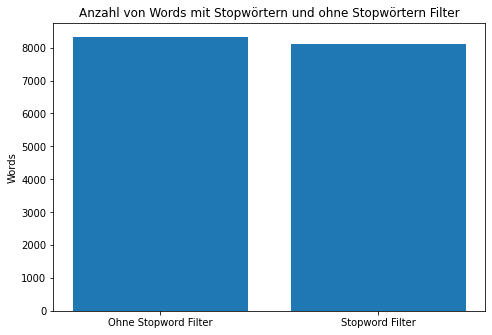

In [9]:
print("** Anzahl von gesammten extrahierten features")
print(numberOfFeatures)

print("** Anzahl von extrahierten features mit Stopword Filter")
print(numberOfFeatures_without_stopwords)
x = ["Ohne Stopword Filter", "Stopword Filter"]
y = [numberOfFeatures, numberOfFeatures_without_stopwords]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(x,y)

ax.set_ylabel("Words")
ax.set_title("Anzahl von Words mit Stopwörtern und ohne Stopwörtern Filter")
plt.show()

Das Diagramm zeigt, dass der Filter die Wortanzahl um etwa 200 reduziert hat

### Exkurs: Einsatz eines Stemmers
Beispiel: https://www.datacamp.com/community/tutorials/stemming-lemmatization-python

Unter Stemming versteht man in der linguistischen Informatik ein Verfahren, mit dem verschiedene morphologische Varianten eines Wortes auf ihren gemeinsamen Wortstamm zurückgeführt werden (3). Ein Beispiel:

Wort -> stem

engineering -> engineer

engineered -> engineer

engineer -> engineer


Zum Stemming gibt es verschiedene Algorithmen für diverse Sprachen. Unsere Datensätze sind auf Englisch und es gibt viele Stemmer, die die Sprache unterstützen (Beispielsweise nltk). Die drei häufig genutzten Algorithmen sind: Snowball, Porter und Lancaster. (4)


* Porter: ist der zurzeit am häufigsten genutzte Stemmer. Der Algorithmus ist sehr rechenintensiv und einer der ältesten Stemming-Algorithmen.

* Snowball: ist ein Verbesserung von Porter. Die Rechenzeit ist etwas schneller als Porter. Der Algorithmus verfügt über eine sehr große Community.

* Lancaster: ist ein sehr aggressiver Stemming-Algorithmus. Lancaster reduziert die Wortanzahl der Datensätze enorm. Wenn man aber mehr Unterscheidung braucht, ist dieser Algorithmus nicht geeigenet.

Der Stemmer lässt sich als "Analyzer" beim CountVectorizer nutzen. 

##  Untersuchung der Stemmer

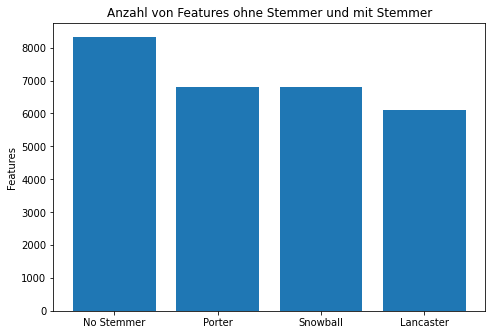

In [10]:
analyzer = CountVectorizer().build_analyzer()

def porterstemmed_words(doc):
    stemmer=PorterStemmer()
    return (stemmer.stem(w) for w in analyzer(doc))

pipe_porter = Pipeline([('vect', CountVectorizer(stop_words="english", analyzer=porterstemmed_words)),
                     ('tfidf', TfidfTransformer())
                         #weitere Elemente für Pipeline
                        ]).fit(df["title"])
def snowballstemmed_words(doc):
    stemmer=SnowballStemmer("english")
    return (stemmer.stem(w) for w in analyzer(doc))

pipe_snowball = Pipeline([('vect', CountVectorizer(stop_words="english", analyzer=snowballstemmed_words)),
                     ('tfidf', TfidfTransformer())
                         #weitere Elemente für Pipeline
                        ]).fit(df["title"])

def lancasterstemmed_words(doc):
    stemmer=LancasterStemmer()
    return (stemmer.stem(w) for w in analyzer(doc))

pipe_lancaster = Pipeline([('vect', CountVectorizer(stop_words="english", analyzer=lancasterstemmed_words)),
                     ('tfidf', TfidfTransformer())
                         #weitere Elemente für Pipeline
                        ]).fit(df["title"])

features_porter = len(pipe_porter['vect'].get_feature_names())
features_snowball = len(pipe_snowball['vect'].get_feature_names())
features_lancaster = len(pipe_lancaster['vect'].get_feature_names())

x = ["No Stemmer", "Porter", "Snowball", "Lancaster"]
y = [numberOfFeatures, features_porter, features_snowball, features_lancaster]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(x,y)

ax.set_ylabel('Features')
ax.set_title('Anzahl von Features ohne Stemmer und mit Stemmer')
plt.show()

Das Diagramm macht deutlich, dass die gesamtanzahl der Wörter circa mehr als 8000 ist. Nach dem Einsatz von Stemmern lässt sich die Anzahl der Features deutlich reduzieren. Nach dem Einsatz von Porter und Snowball liegt die Anzahl etwa auf 6800. Anschließend zeigt sich, dass der Lancaster Algorithmus die Anzahl von Features am meisten (auf ungefähr 6000) verringert.

Interessant ist ob der Einsatz eines Stemmers das Ergebnis der Vorhersage verbessert.

Nachdem die Text Daten extrahiert und vektorisiert worden sind, sind die Daten bereit für das Training eines Klassifikators. Es gibt viele Algorithmen für einen Klassifikator, z.B Logistische Regression, Naive Bayes, Random Forest, .... Abhängig von dem Datenbestand lässt sich jeder Algorithmus unterschiedlich effizient einsetzen. Im Rahmen unserer Arbeit werden wir zuerst die Logistische Regression als Base-Line Klassifikator nutzen.

Logistische Regression lässt sich mit Hilfe von scikit-learn und Pipeline sehr einfach umsetzen. Der Logistische Regression Klassifikator kann unter "sklearn.linear_model.LogisticRegression" gefunden werden.

Aufbau der Basis-Pipeline:
   
    * Text Features Extraction (mit CountTokenizer)
    * Text Features Normalisieren (mit TfidfTransformer)
    * Klassifikationsalgorithmus
    
In den gegebenen Trainingsdaten befinden sich zwei Text-Features-Spalten ("title" und "text"). Diese Spalten können unterschieliche Rollen bei der Vorhersage spielen, z.B anhand Title lässt sich ein Datensatz besser einer Klasse zuordnen. Die Spalten können unterschiedliche Gewichtungen haben und sollten deshalb getrennt betrachtet werden und am Ende zusammengefasst werden. 

Diese Vorgehensweise kann mit Hilfe von "Feature Union" Feature von scikit-learn umgesetzt werden. Die Klasse "FeatureUnion" von "sklearn.pipeline" sollte dafür importiert werden. Außerdem sollte die entsprechende Feature-Spalte anfangs der Pipeline entnommen werden, dafür ist ein Spaltenselektor nötig.

## Implementierung des Feature-Spaltenselektor

In [5]:
class FeatureColumnSelector():
    # Name der Spalte sollte angegeben werden
    def __init__(self, name):
        self.name = name

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.name]

## Klassifikatoren

In [12]:
# Zuerst definieren wir einen Test-Datensatz
# Der Datensatz wurde von den Trainigsdaten entnommen
test_data=[]
test_data.append({"title": "Top 10 Web 2 0 Startups Taking Over the World", 
                  "text": "Written By Drew August 22nd 2011 If one looks at a calendar you d think it was the 1990 s again We re in the midst of a huge boom in web startups with seemingly hundreds starting up every month With new formats to explore smartphones tablets etc the startups of today have a much bigger advantage that the startups of yesteryear With technology racing at a breakneck clip the number of startups will only increase with faster speeds and better tools to work with We ll be looking at ten startups to watch out for in the next few months 1 Red Nova Labs Started in 2009 Red Nova Labs started as a marketing agency and web development company Servicing interface designs and online marketing RNL has been a leader in these developments since their inception It also serves its customers with back end programming and launching web based platforms With a crack team of developers and engineers complex programming also helps its clients maintain their edge in cyberspace Some projects that RNL has been involved with are storagefront com lenderstreet com and many other genres of websites 2 Getchabooks This startup was founded by three college undergrads to combat a common problem among college students where to get the cheapest textbooks Taking a different approach than other college books sites Getchabooks is focused around courses instead of typing full class names Using Amazon as a drop shipper has saved the trio from additional shipping and inventory costs For any student looking at a simple and easy way to check for the best price on textbooks the upcoming semester should be made easier with Getchabooks 3 Lawpivot Q A sites are becoming very popular especially for legal based questions Rocket Lawyer and LegalZoom are the two big elephants in the room in this field but new startup Lawpivot seeks to change that Started up by a team of tech executives and lawyers Lawpivot is backed by Google Ventures Lawpivot focuses on business related law and has recently opened their services to the public for business owners to ask legal questions Such categories as immigration law employment tax contracts intellectual property and corporations are covered in Lawpivot 4 Ooyala Ooyala is an online video service provider that s based out of Mountain View California Started in 2007 Ooyala has slowly risen up the ranks of providers and now is considered the fasting growing provider in the country Ooyala has scored a major coup by partnering with ESPN in their online streams and broadcasting Ooyala has also brokered a deal with Yahoo Japan to be the video provider for their site Ooyala is poised to supply online video for over half of Japanese online video viewerships With these recent successes it seems that the sky is the limit for Ooyala 5 Umami Not too much is known about this NY based startup it s not stopped positive fund raising to get off the ground though Umami currently has a closed beta app for the iPad and is set for a launch of the fall television season Umami will show TV viewers added content to their shows and have advertisements based around the show they re watching Umami has much competition in this area and time will tell who will come out of this the winner 6 Milewise People with frequent flier miles are always on the lookout as to where they can spend their miles on flights Milewise knows this and has a search engine catered especially for the frequent flier You can also keep track of your FF miles and reward program points with Milewise Milewise takes all of this into account when making suggestions on flights based on your information Milewise supports over 300 rewards programs and can notify you when points or rewards are set to expire 7 Birchbox This is a subscription based site which centers around makeup and beauty products Founded by Katia Beauchamp and Hayley Barna in 2010 Birchbox as of June 2011 now has 45 000 subscribers Users fill out a survey about themselves and what they like makeup wise and Birchbox personalizes suites of products based around the consumer and their likes and dislikes 8 Punchd Punchd is a digital reward card app that consumers can use to get rewards down the line Similar to punch cards buy four of an item and get one free etc Punchd does away with actually punch cards and instead puts the card as an app on your cell phone Customers scan QR codes that are printed on the receipt of their order with a smartphone and it s instantly punched and saved via cloud storage 9 Drchrono Drchrono is an application for the iPad that allows Doctors to schedule patient appointments note dictation and writing prescriptions all from their iPad Looking to replace the clipboard Drchrono is marketing their services nationwide With the Obama Administration now offering incentives for Doctors to move their patients health records online Drchrono seems to be just the company to help the medical field achieve this goal 10 GoodData GoodData is a data analytics solution company which is cloud based providing graphs and data visualization tools for business owners GoodData provides many data services for business owners wishing to analyze key departments for later improvement Using operational dashboards data warehousing and advanced reporting programs GoodData is keen on bookending this specialized market About Drew SEO and Social Media Specialist in the Kansas City Kansas area web 2.0 startups are beginning to take over the world at an alarming rate and bringing new and innovative ideas to the table. startups, web startups",
                  "target": "0"
                 })

df_test_alone = pd.DataFrame(test_data)

In [13]:
# Pipeline des Basis Klassifikators
# Ohne Stemmer, ohne Stopwörter Filter
pipeline = Pipeline([
    ("union", FeatureUnion(
        transformer_list = [
            # Pipeline fürs Entnehmen der Features "title" and "text"
            ("title", Pipeline([
                ("selector", FeatureColumnSelector(name="title")),
                ("count", CountVectorizer()),
                ("tfidf", TfidfTransformer())
            ])),
            ("text", Pipeline([
                ("selector", FeatureColumnSelector(name="text")),
                ("count", CountVectorizer()),
                ("tfidf", TfidfTransformer())
            ])),
        ],
        # Gewichtung der Features
        # In diesem Fall ist 'title' doppelt so stark gewichtet wie 'text'
        transformer_weights={
            "title": 2,
            "text": 1,
        },
    )),
    # LogisticRegression Klassifikator
    ("clf", LogisticRegression())
])

# Erzeugen eines Klassifikator
clf = pipeline.fit(df_train[["title", "text"]], df_train["label"])
# Jetzt lassen wir etwas vom Klassifikator vorhersagen
print(clf.predict(df_test_alone[["title", "text"]]))
print(clf.predict_proba(df_test_alone[["title", "text"]]))

[0]
[[0.84194124 0.15805876]]


Der Klassifikator hat funktioniert. Er klassifiziert den Test-Datensatz als 84,19% zur Klasse "0" und 15,80% zur Klasse "1". Der Datensatz wird somit als Klasse "0" vorhergesagt, was zu erwarten war.

Jetzt filtern wir die Stopwörter raus und trainieren den Klassifikator erneut.

In [14]:
pipeline_stopwords_filtered = Pipeline([
    ("union", FeatureUnion(
        transformer_list = [
            # Pipeline fürs Entnehmen der Features "title" and "text"
            ("title", Pipeline([
                ("selector", FeatureColumnSelector(name="title")),
                ("count", CountVectorizer(stop_words="english")),
                ("tfidf", TfidfTransformer())
            ])),
            ("text", Pipeline([
                ("selector", FeatureColumnSelector(name="text")),
                ("count", CountVectorizer(stop_words="english")),
                ("tfidf", TfidfTransformer())
            ])),
        ],
        # Gewichtung der Features
        # In diesem Fall ist Title doppelt wichtiger als text
        transformer_weights={
            "title": 2,
            "text": 1,
        },
    )),
    ("clf", LogisticRegression())
])
# Erzeugen eines Klassifikator
clf_stopwords_filtered = pipeline_stopwords_filtered.fit(df_train[["title", "text"]], df_train["label"])
print(clf_stopwords_filtered.predict(df_test_alone[["title", "text"]]))
print(clf_stopwords_filtered.predict_proba(df_test_alone[["title", "text"]]))

[0]
[[0.86384817 0.13615183]]


Die Qualität des Klassifikators hat sich etwas verbessert. Der Klassifikator klassifiziert den Test-Datensatz zu circa 86,38% zu der Klasse 0.

Es wird untersucht, ob der Einsatz eines Stemmers den Klassifikator verbessert. 

Zuerst ist der Snowball Algorithmus im Einsatz.

In [15]:
pipeline_snowballstemmed = Pipeline([
    ("union", FeatureUnion(
        transformer_list = [
            # Pipeline fürs Entnehmen der Features "title" and "text"
            ("title", Pipeline([
                ("selector", FeatureColumnSelector(name="title")),
                ("count", CountVectorizer(stop_words="english", analyzer=snowballstemmed_words)),
                ("tfidf", TfidfTransformer())
            ])),
            ("text", Pipeline([
                ("selector", FeatureColumnSelector(name="text")),
                ("count", CountVectorizer(stop_words="english", analyzer=snowballstemmed_words)),
                ("tfidf", TfidfTransformer())
            ])),
        ],
        # Gewichtung der Features
        # In diesem Fall ist Title doppelt wichtiger als text
        transformer_weights={
            "title": 2,
            "text": 1,
        },
    )),
    ("clf", LogisticRegression())
])
# Erzeugen eines Klassifikator
clf_snowballstemmed = pipeline_snowballstemmed.fit(df_train[["title", "text"]], df_train["label"])
print(clf_snowballstemmed.predict(df_test_alone[["title", "text"]]))
print(clf_snowballstemmed.predict_proba(df_test_alone[["title", "text"]]))

[0]
[[0.81697261 0.18302739]]


Die Vorhersage hat sich etwas verschlechtert, aber das Ergebnis ist weiterhin richtig. Wir wäre es mit dem Lancaster Stemmer?

In [16]:
pipeline_lancasterstemmed = Pipeline([
    ("union", FeatureUnion(
        transformer_list = [
            ("title", Pipeline([
                ("selector", FeatureColumnSelector(name="title")),
                ("count", CountVectorizer(stop_words="english", analyzer=lancasterstemmed_words)),
                ("tfidf", TfidfTransformer())
            ])),
            ("text", Pipeline([
                ("selector", FeatureColumnSelector(name="text")),
                ("count", CountVectorizer(stop_words="english", analyzer=lancasterstemmed_words)),
                ("tfidf", TfidfTransformer())
            ])),
        ],
        transformer_weights={
            "title": 2,
            "text": 1,
        },
    )),
    #Use naive bayes on combined features
    ("clf", LogisticRegression())
])
clf_lancasterstemmed = pipeline_lancasterstemmed.fit(df_train[["title", "text"]], df_train["label"])
print(clf_lancasterstemmed.predict(df_test_alone[["title", "text"]]))
print(clf_lancasterstemmed.predict_proba(df_test_alone[["title", "text"]]))

[0]
[[0.786566 0.213434]]


Als letztes wird Port Stemmer getestet.

In [17]:
pipeline_porterstemmed = Pipeline([
    ("union", FeatureUnion(
        transformer_list = [
            ("title", Pipeline([
                ("selector", FeatureColumnSelector(name="title")),
                ("count", CountVectorizer(stop_words="english", analyzer=porterstemmed_words)),
                ("tfidf", TfidfTransformer())
            ])),
            ("text", Pipeline([
                ("selector", FeatureColumnSelector(name="text")),
                ("count", CountVectorizer(stop_words="english", analyzer=porterstemmed_words)),
                ("tfidf", TfidfTransformer())
            ])),
        ],
        transformer_weights={
            "title": 2,
            "text": 1,
        },
    )),
    ("clf", LogisticRegression())
])
clf_porterstemmed = pipeline_porterstemmed.fit(df_train[["title", "text"]], df_train["label"])
print(clf_porterstemmed.predict(df_test_alone[["title", "text"]]))
print(clf_porterstemmed.predict_proba(df_test_alone[["title", "text"]]))

[0]
[[0.80627238 0.19372762]]


## Evaluation

Bei den durchgeführten Tests haben sich die Vorhersagen als richtig erwiesen und zwar mit einer großen Genauigkeit. Jedoch lässt sich nicht mit nur einem Test sagen, ob der Klassifikator sich auch für andere Daten eignet. Der Klassifikator sollte auf eine große Menge von Datensätzen getestet werden.

### ROC-Kurve

Als Qualitätskriterium steht die AUC (area under curve) der ROC-Kurve zur Verfügung. Die ROC-Kurve stellt visuell die Abhängigkeit der Effizienz mit der Fehlerrate für verschiedene Parameterwerte dar.

Hierfür wird 1/3 der Datensätze verwendet, welche im oberen Schritt schon aufgeteilt worden sind und unter "df_test" zur Verfügung stehen.

Die folgende ROC-Kurve wird für die oben definierten Klassifikatoren mithilfe von Scikit-learn erstellt.

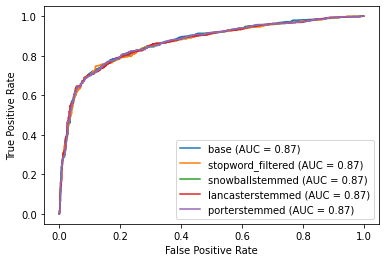

In [18]:
roc = metrics.plot_roc_curve(pipeline, df_test[["title", "text"]], df_test["label"],  name="base")
roc = metrics.plot_roc_curve(pipeline_stopwords_filtered, df_test[["title", "text"]], df_test["label"],  name="stopword_filtered", ax=roc.ax_)
roc = metrics.plot_roc_curve(pipeline_snowballstemmed, df_test[["title", "text"]], df_test["label"],  name="snowballstemmed", ax=roc.ax_)
roc = metrics.plot_roc_curve(pipeline_lancasterstemmed, df_test[["title", "text"]], df_test["label"],  name="lancasterstemmed", ax=roc.ax_)
roc = metrics.plot_roc_curve(pipeline_porterstemmed, df_test[["title", "text"]], df_test["label"],  name="porterstemmed", ax=roc.ax_)

plt.show()

### ROC-Kurve Intepretation (5)

Eine ROC-Kurve nahe der Diagonalen deutet auf einen Zufallsprozess hin: Werte die sich in der Nähe der Diagonalen befinden, bedeuten eine gleiche Trefferquote und Falschpositivquote, was der zu erwartenden Trefferhäufigkeit eines Zufallsprozesses entspricht. 

Die ideale ROC-Kurve steigt zunächst senkrecht an (die Trefferquote liegt nahe bei 100 %, während die Fehlerquote anfangs noch nahe bei 0 % bleibt), erst danach steigt die Falsch-Positiv-Rate an. Eine ROC-Kurve, die deutlich unterhalb der Diagonalen bleibt, deutet darauf hin, dass die Werte falsch interpretiert wurden.

In der oberen Grafik ist die Kurve von einer Diagonalen entfernt. Daraus schließt sich, dass alle Klassifikatoren keine zufälligen Vorhersagen machen und sich zum klassifizieren eignen. Im Allgemeinen gibt es jedoch keine großen Unterschiede zwischen Klassifikatoren mit dem Einsatz verschiedener Stemmer.

## Feature Selection

Im Machine Learning spielen die Daten eine sehr wichtige Rolle und wenn die Daten schlecht sind, sind die Vorhersagen folglich auch schlecht. Bei Text Klassifikatoren ist jedes Wort ein Feature und deshalb sind die Anzahl von Features üblicherweise sehr groß, wobei viele Worte gar nicht wichtig sind (z.B: Stopwörter) oder weniger wichtig sind (z.B Wörter, die in allen Datensätz existieren). Diese Wörter beeinflussen negativ die Genauigkeit der Vorhersage und verlangsamen das Training. Deshalb wird "Feature Selection" benötigt, um diese Wörtern zu erkennen und herauszufiltern.

Die Gründe, um Feature Selection einzusetzen sind: (6)

* Beschleunigung des Tranings
* Reduktion der Komlexität eines Models und der Vereinfachung der Interpretation
* Erhöhung der Genauigkeit der Vorhersage
* Overfitting-Reduktion


### Mutual Information

Mutual Information ist eine Größe aus der Informationstheorie, die die Stärke des statistischen Zusammenhangs zweier Zufallsgrößen angibt.(7)

Bei der Feature Selection möchten wir die Mutual Information zwischen den Features Zielklassen maximieren. Das heißt, wir berechnen die Mutual Information von Features und behalten die Wörter, die mehr mit der Zielklasse zusammenhängen (hohe Mutual Information mit der Zielklasse)

Feature Selection anhand von Mutual Information wird auch von Scikit-Learn unterstützt, unter Verwendung der Klasse "SelectKBest" und "mutual_info_classif" von "sklearn.feature_selection"(8). Folgendes zeigt die Verwendung von Feature Selection anhand der Mutual Information.

In [20]:
vectorizer = CountVectorizer()
wordcount = vectorizer.fit_transform(df["text"])
selectKBest = SelectKBest(mutual_info_classif, k=100)
X_new = selectKBest.fit_transform(wordcount, df["label"])

new_features_indices = selectKBest.get_support(indices=True)
print("100 Wörter mit hohen Mutual Information")
for indices in new_features_indices: 
    print(vectorizer.get_feature_names()[indices])

100 Wörter mit hohen Mutual Information
350
add
and
bake
baked
baking
bowl
brown
butter
cake
cheese
chicken
chocolate
chopped
combine
cook
cooked
cooking
cool
cream
cup
cups
cut
degrees
delicious
dish
dough
dry
easy
egg
eggs
evenly
flavor
flour
food
for
fresh
garlic
heat
in
inch
ingredients
into
kitchen
large
lightly
make
medium
melted
milk
minutes
mix
mixture
my
oil
olive
onion
or
oven
over
pan
pepper
place
pour
powder
preheat
rack
recipe
recipes
remove
salt
sauce
serve
serving
sheet
sides
small
smooth
spoon
sprinkle
stir
sugar
sweet
tablespoon
tablespoons
taste
teaspoon
temperature
the
to
together
tsp
until
vanilla
warm
water
whisk
with
you
your


Das Ergebnis zeigt, dass die relavanten Wörter für die Klassifikation in Verbindung mit Essen stehen.

Der darauffolgende Test wird zeigen, ob der Einsatz von Feature Selection mit Mutual Information die Qualität des getesteten Klassifikators (Wir werden den Klassifikator mit Stopword Filter und Porter Stemmer nutzen) verbessert.

In [21]:
# Wir werden die 1000 wichtigsten Wörter filtern und als Basis für das Training verwenden.
pipeline_featureselection = Pipeline([
    ("union", FeatureUnion(
        transformer_list = [
            ("title", Pipeline([
                ("selector", FeatureColumnSelector(name="title")),
                ("count", CountVectorizer(stop_words="english", analyzer=porterstemmed_words)),
                ("feature_selection", SelectKBest(mutual_info_classif, k=1000)),
                ("tfidf", TfidfTransformer())
            ])),
            ("text", Pipeline([
                ("selector", FeatureColumnSelector(name="text")),
                ("count", CountVectorizer(stop_words="english", analyzer=porterstemmed_words)),
                ("feature_selection", SelectKBest(mutual_info_classif, k=1000)),
                ("tfidf", TfidfTransformer())
            ])),
        ],
        transformer_weights={
            "title": 2,
            "text": 1,
        },
    )),
    ("clf", LogisticRegression())
])
clf_featureselection = pipeline_featureselection.fit(df_train[["title", "text"]], df_train["label"])
print(clf_featureselection.predict(df_test_alone[["title", "text"]]))
print(clf_featureselection.predict_proba(df_test_alone[["title", "text"]]))

[0]
[[0.84633879 0.15366121]]


Hier könnte es länger dauern, weil die Feature Selection etwas Zeit braucht, um die Features zu bewerten. Jetzt werden wir nocheinmal die ROC Kurve verwenden, um den Klassifikator zu evaluieren.

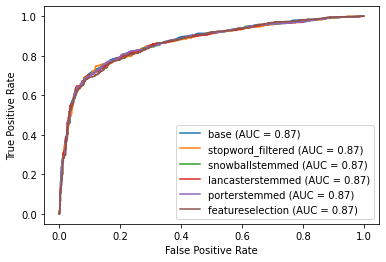

In [22]:
roc = metrics.plot_roc_curve(pipeline, df_test[["title", "text"]], df_test["label"],  name="base")
roc = metrics.plot_roc_curve(pipeline_stopwords_filtered, df_test[["title", "text"]], df_test["label"],  name="stopword_filtered", ax=roc.ax_)
roc = metrics.plot_roc_curve(pipeline_snowballstemmed, df_test[["title", "text"]], df_test["label"],  name="snowballstemmed", ax=roc.ax_)
roc = metrics.plot_roc_curve(pipeline_lancasterstemmed, df_test[["title", "text"]], df_test["label"],  name="lancasterstemmed", ax=roc.ax_)
roc = metrics.plot_roc_curve(pipeline_porterstemmed, df_test[["title", "text"]], df_test["label"],  name="porterstemmed", ax=roc.ax_)
roc = metrics.plot_roc_curve(pipeline_featureselection, df_test[["title", "text"]], df_test["label"],  name="featureselection", ax=roc.ax_)

plt.show()

Jetzt untersuchen wir, ob der Klassifikator sich verändert, wenn die Anzahl der reduzierten Features variiert.

[0]
[[0.87437983 0.12562017]]


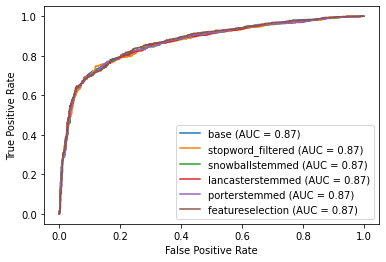

In [22]:
# Wir werden die 2000 wichtigsten Wörter filtern und als Basis fürs Training verwenden
pipeline_featureselection = Pipeline([
    ("union", FeatureUnion(
        transformer_list = [
            ("title", Pipeline([
                ("selector", FeatureColumnSelector(name="title")),
                ("count", CountVectorizer(stop_words="english", analyzer=porterstemmed_words)),
                ("feature_selection", SelectKBest(mutual_info_classif, k=2000)),
                ("tfidf", TfidfTransformer())
            ])),
            ("text", Pipeline([
                ("selector", FeatureColumnSelector(name="text")),
                ("count", CountVectorizer(stop_words="english", analyzer=porterstemmed_words)),
                ("feature_selection", SelectKBest(mutual_info_classif, k=2000)),
                ("tfidf", TfidfTransformer())
            ])),
        ],
        transformer_weights={
            "title": 2,
            "text": 1,
        },
    )),
    ("clf", LogisticRegression())
])
clf_featureselection = pipeline_featureselection.fit(df_train[["title", "text"]], df_train["label"])
print(clf_featureselection.predict(df_test_alone[["title", "text"]]))
print(clf_featureselection.predict_proba(df_test_alone[["title", "text"]]))

roc = metrics.plot_roc_curve(pipeline, df_test[["title", "text"]], df_test["label"],  name="base")
roc = metrics.plot_roc_curve(pipeline_stopwords_filtered, df_test[["title", "text"]], df_test["label"],  name="stopword_filtered", ax=roc.ax_)
roc = metrics.plot_roc_curve(pipeline_snowballstemmed, df_test[["title", "text"]], df_test["label"],  name="snowballstemmed", ax=roc.ax_)
roc = metrics.plot_roc_curve(pipeline_lancasterstemmed, df_test[["title", "text"]], df_test["label"],  name="lancasterstemmed", ax=roc.ax_)
roc = metrics.plot_roc_curve(pipeline_porterstemmed, df_test[["title", "text"]], df_test["label"],  name="porterstemmed", ax=roc.ax_)
roc = metrics.plot_roc_curve(pipeline_featureselection, df_test[["title", "text"]], df_test["label"],  name="featureselection", ax=roc.ax_)

plt.show()

[0]
[[0.82903178 0.17096822]]


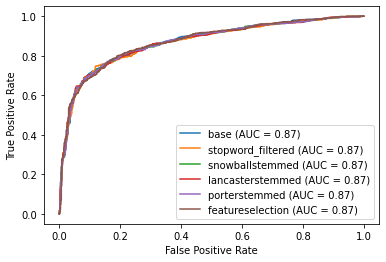

In [23]:
# Wir werden die 3000 wichtigsten Wörter filtern und als Basis fürs Training verwenden
pipeline_featureselection = Pipeline([
    ("union", FeatureUnion(
        transformer_list = [
            ("title", Pipeline([
                ("selector", FeatureColumnSelector(name="title")),
                ("count", CountVectorizer(stop_words="english", analyzer=porterstemmed_words)),
                ("feature_selection", SelectKBest(mutual_info_classif, k=3000)),
                ("tfidf", TfidfTransformer())
            ])),
            ("text", Pipeline([
                ("selector", FeatureColumnSelector(name="text")),
                ("count", CountVectorizer(stop_words="english", analyzer=porterstemmed_words)),
                ("feature_selection", SelectKBest(mutual_info_classif, k=3000)),
                ("tfidf", TfidfTransformer())
            ])),
        ],
        transformer_weights={
            "title": 2,
            "text": 1,
        },
    )),
    ("clf", LogisticRegression())
])
clf_featureselection = pipeline_featureselection.fit(df_train[["title", "text"]], df_train["label"])
print(clf_featureselection.predict(df_test_alone[["title", "text"]]))
print(clf_featureselection.predict_proba(df_test_alone[["title", "text"]]))

roc = metrics.plot_roc_curve(pipeline, df_test[["title", "text"]], df_test["label"],  name="base")
roc = metrics.plot_roc_curve(pipeline_stopwords_filtered, df_test[["title", "text"]], df_test["label"],  name="stopword_filtered", ax=roc.ax_)
roc = metrics.plot_roc_curve(pipeline_snowballstemmed, df_test[["title", "text"]], df_test["label"],  name="snowballstemmed", ax=roc.ax_)
roc = metrics.plot_roc_curve(pipeline_lancasterstemmed, df_test[["title", "text"]], df_test["label"],  name="lancasterstemmed", ax=roc.ax_)
roc = metrics.plot_roc_curve(pipeline_porterstemmed, df_test[["title", "text"]], df_test["label"],  name="porterstemmed", ax=roc.ax_)
roc = metrics.plot_roc_curve(pipeline_featureselection, df_test[["title", "text"]], df_test["label"],  name="featureselection", ax=roc.ax_)

plt.show()

[0]
[[0.81094975 0.18905025]]


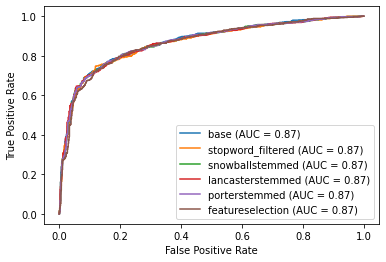

In [24]:
# Wir werden die 500 wichtigsten Wörtern filtern und als Basis fürs Training verwenden
pipeline_featureselection = Pipeline([
    ("union", FeatureUnion(
        transformer_list = [
            ("title", Pipeline([
                ("selector", FeatureColumnSelector(name="title")),
                ("count", CountVectorizer(stop_words="english", analyzer=porterstemmed_words)),
                ("feature_selection", SelectKBest(mutual_info_classif, k=500)),
                ("tfidf", TfidfTransformer())
            ])),
            ("text", Pipeline([
                ("selector", FeatureColumnSelector(name="text")),
                ("count", CountVectorizer(stop_words="english", analyzer=porterstemmed_words)),
                ("feature_selection", SelectKBest(mutual_info_classif, k=500)),
                ("tfidf", TfidfTransformer())
            ])),
        ],
        transformer_weights={
            "title": 2,
            "text": 1,
        },
    )),
    ("clf", LogisticRegression())
])
clf_featureselection = pipeline_featureselection.fit(df_train[["title", "text"]], df_train["label"])
print(clf_featureselection.predict(df_test_alone[["title", "text"]]))
print(clf_featureselection.predict_proba(df_test_alone[["title", "text"]]))

roc = metrics.plot_roc_curve(pipeline, df_test[["title", "text"]], df_test["label"],  name="base")
roc = metrics.plot_roc_curve(pipeline_stopwords_filtered, df_test[["title", "text"]], df_test["label"],  name="stopword_filtered", ax=roc.ax_)
roc = metrics.plot_roc_curve(pipeline_snowballstemmed, df_test[["title", "text"]], df_test["label"],  name="snowballstemmed", ax=roc.ax_)
roc = metrics.plot_roc_curve(pipeline_lancasterstemmed, df_test[["title", "text"]], df_test["label"],  name="lancasterstemmed", ax=roc.ax_)
roc = metrics.plot_roc_curve(pipeline_porterstemmed, df_test[["title", "text"]], df_test["label"],  name="porterstemmed", ax=roc.ax_)
roc = metrics.plot_roc_curve(pipeline_featureselection, df_test[["title", "text"]], df_test["label"],  name="featureselection", ax=roc.ax_)

plt.show()

Nach der Untersuchung der Feature Selection und der Evaluation lässt sich sagen, dass Feature Selection den Klassifikator nicht großartig verbessert hat.

### Tunning Parameter: Grid Search / Random Search

Für jedes Model, das man für das Training verwenden würde, sind die Parameter ein unverzichtbarer Teil. z.B beim Random Forest sind die Parameter Beispielsweise: n_estimators, max_features, max_depth, min_samples_split.  Unterschiedliche Parameterkombinationen beeinflussen die Genauigkeit des Models und der Vorhersage. Abhängig von dem konkreten Problem und Anzahl der vorhandenen Daten sind die passenden Parameter unterschiedlich. Es ist notwendig, verschiedene Parameter auszuprobieren, um die optimalen Parameter zu finden.

In der Praxis werden hauptsächlich zwei Methoden verwendet, um Hyperparameter zu finden. Das sind "Grid Search" und "Random Search". Nachfolgend werden die Methoden beschrieben. (9)

* Grid Search: Grid Search probiert alle Kombination von Parametern aus und berechnet die Genauigkeit des Models. Der Vorteil dieser Methode ist, dass keine Kombination von Parametern verpasst wird, und der optimalste Parameter ermittelt wird. Der Nachteil jedoch ist, dass die Versuche extrem zeitintensiv sein könnten, wenn es zu viele Parameter gibt. Es könnte Stunden, Tage und sogar Monate dauern.
* Random Search: Wie der Name der Methode besagt, bei Random Search werden nur zufällige Kombinationen ausprobiert. Das heiß also, dass nicht alle Kombinationen für die Ermittlung der Genauigkeit verwendet werden und der optimalste Hyperparameter verpasst werden könnte. Im Vergleich zu Grid Search ist Random Search schneller. Random Search wird empfohlen, wenn der Search Raum mehr als drei Dimensionen hat. Random Search wäre zeitlich effizienter, wenn es zu viele Parameter gibt.

Beide oben genannten Methoden lassen sich mit scikit-learn implementieren. Nachfolgend wird Grid Search verwendet, um den besten Hyperparameter für das Logistische Regression Model zu finden.

In [27]:
# Parameter Beschreibung von 
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
param_grid = {
    # C: Inverse of regularization strength; must be a positive float. 
    # Like in support vector machines, smaller values specify stronger regularization.
    "clf__C": np.logspace(-5, 5, 30),
    # Used to specify the norm used in the penalization.
    # Die einzige Wahl ist "l2", weil "lbfgs" "l1" nicht unterstützt
    "clf__penalty": ["l2"],
    # Algorithm to use in the optimization problem.
    # Wir tunnen nur zwischen "lbfgs" und "liblinear"
    # Weil lbfsg default ist und liblinear wird empfohlen, wenn nur kleine Anzahl von Datensätzen vorhanden ist
    # und es nur zwei Zielklassen gibt
    "clf__solver": ["lbfgs", "liblinear"]
}

pipeline_paratunning = Pipeline([
    ("union", FeatureUnion(
        transformer_list = [
            ("title", Pipeline([
                ("selector", FeatureColumnSelector(name="title")),
                ("count", CountVectorizer(stop_words="english")),
                ("tfidf", TfidfTransformer())
            ])),
            ("text", Pipeline([
                ("selector", FeatureColumnSelector(name="text")),
                ("count", CountVectorizer(stop_words="english")),
                ("tfidf", TfidfTransformer())
            ])),
        ],
        transformer_weights={
            "title": 2,
            "text": 1,
        },
    )),
    ("clf", LogisticRegression(max_iter=10000))
])

tunned_clf = GridSearchCV(pipeline_paratunning, param_grid)

clf_paratunning = tunned_clf.fit(df_train[["title", "text"]], df_train["label"])

print('Best Penalty:', tunned_clf.best_estimator_.get_params()["clf__penalty"])
print('Best C:', tunned_clf.best_estimator_.get_params()["clf__C"])
print("Best Solver", tunned_clf.best_estimator_.get_params()["clf__solver"])


print(clf_paratunning.predict(df_test_alone[["title", "text"]]))
print(clf_paratunning.predict_proba(df_test_alone[["title", "text"]]))


Best Penalty: l2
Best C: 0.1373823795883264
Best Solver lbfgs
[0]
[[0.72997276 0.27002724]]


Nach dem Tunning haben wir die optimalsten Parameter bekommen. Das Tunning ist sehr rechenaufwändig, deshalb lassen sich im Rahmen dieser Arbeit nicht alle möglichen Parameter ausprobieren. Wenn man einen stärkeren Rechner hätte, könnten noch bessere Parameter gefunden werden.

Die gefundenen Parameter, können jetzt in unserem besten Klassifikator (mit Stopword Filter, Porter Stemmer und Feature Selection mit 2000 höchstbewerteten Features) eingesetzt werden. Wir haben den besten Klassifikator nicht beim Tunning eingesetzt, weil das Training des Klassifikators an sich schon sehr aufwändig ist und in Kombination mit den anderen Operationen noch länger dauern würde.

In [28]:
pipeline_paratunning = Pipeline([
    ("union", FeatureUnion(
        transformer_list = [
            ("title", Pipeline([
                ("selector", FeatureColumnSelector(name="title")),
                ("count", CountVectorizer(stop_words="english", analyzer=porterstemmed_words)),
                ("feature_selection", SelectKBest(mutual_info_classif, k=2000)),
                ("tfidf", TfidfTransformer())
            ])),
            ("text", Pipeline([
                ("selector", FeatureColumnSelector(name="text")),
                ("count", CountVectorizer(stop_words="english", analyzer=porterstemmed_words)),
                ("feature_selection", SelectKBest(mutual_info_classif, k=2000)),
                ("tfidf", TfidfTransformer())
            ])),
        ],
        transformer_weights={
            "title": 2,
            "text": 1,
        },
    )),
    ("clf", LogisticRegression(C=0.13738, penalty="l2", solver="lbfgs",max_iter=10000))
])

clf_paratunning = pipeline_paratunning.fit(df_train[["title", "text"]], df_train["label"])

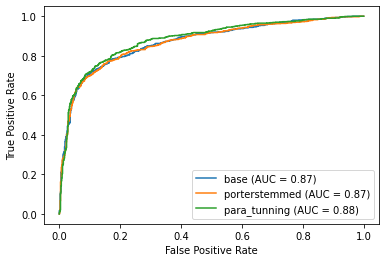

In [29]:
roc = metrics.plot_roc_curve(pipeline, df_test[["title", "text"]], df_test["label"],  name="base")
roc = metrics.plot_roc_curve(pipeline_porterstemmed, df_test[["title", "text"]], df_test["label"],  name="porterstemmed", ax=roc.ax_)
roc = metrics.plot_roc_curve(pipeline_paratunning, df_test[["title", "text"]], df_test["label"],  name="para_tunning", ax=roc.ax_)

plt.show()

Das Ergebnis is positiv. Der AUC-Wert ist auf 0.88 gestiegen.

Nach der Untersuchung haben wir den optimalsten Klassifikator gefunden. Jetzt ist die Zeit für die letzte Evaluation gekommen.

### Evaluation auf der Testmenge

In [30]:
# Da Sie das Test-Set nicht haben, Führen Sie dies mit den ursprünglichen Daten durch:
df_test = pd.read_csv('data_beleg.csv', encoding='utf-8')
# Wird von mir ersetzt durch
# df_test = pd.read_csv('data_test.csv', encoding='utf-8')
# und sollte dann auch durchlaufen!

In [31]:
y_test_true = df_test["label"] # Variable für die Ground Truth des Test-Datensatzes. 

In [32]:
# Wenden Sie hier ihre Vorverarbeitung/Klassifikation ihres entgültigen Modells 
# an. 

# Unser Klassifikator

final_pipeline = Pipeline([
    ("union", FeatureUnion(
        transformer_list = [
            ("title", Pipeline([
                ("selector", FeatureColumnSelector(name="title")),
                ("count", CountVectorizer(stop_words="english", analyzer=porterstemmed_words)),
                ("feature_selection", SelectKBest(mutual_info_classif, k=2000)),
                ("tfidf", TfidfTransformer())
            ])),
            ("text", Pipeline([
                ("selector", FeatureColumnSelector(name="text")),
                ("count", CountVectorizer(stop_words="english", analyzer=porterstemmed_words)),
                ("feature_selection", SelectKBest(mutual_info_classif, k=2000)),
                ("tfidf", TfidfTransformer())
            ])),
        ],
        transformer_weights={
            "title": 2,
            "text": 1,
        },
    )),
    ("clf", LogisticRegression(C=0.13738, penalty="l2", solver="lbfgs"))
])
# Training des Klassifikator
final_clf = final_pipeline.fit(df[["title", "text"]], df["label"])

prediction_proba = final_pipeline.predict_proba(df_test[["title", "text"]])

In [33]:
# In dieser Variable sollte die Vorhersagewahrscheinlichkeit für die positive Klasse
# p(y=1 | x) gespeichte sein.
y_test_prob_class_1 = list(map(lambda x : x[1], prediction_proba))

In [34]:
# This is the ROC-AUC evaluation metric for the test data set:
sklearn.metrics.roc_auc_score(y_test_true, y_test_prob_class_1)

0.933490293524069

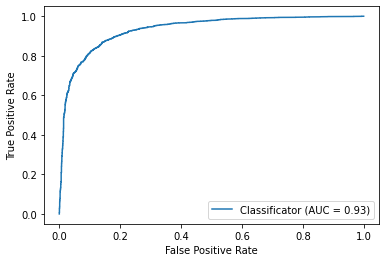

In [35]:
# ROC-Kurve
roc = metrics.plot_roc_curve(final_pipeline, df_test[["title", "text"]], df_test["label"],  name="Classificator")

plt.show()

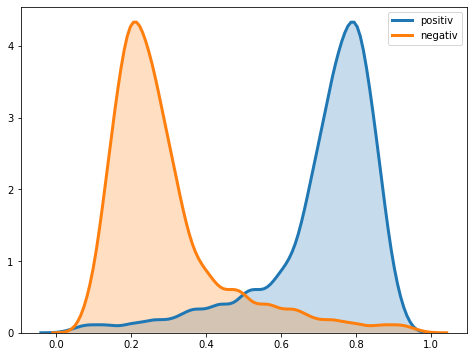

In [36]:
# ROC Histogram

zero_index = df_test[df_test.label==0].index #assume 0 is negativ
one_index = df_test[df_test.label==1].index #assume 1 is positiv

zero_prob = prediction_proba[zero_index]
one_prob = prediction_proba[one_index]
positive_prob = list(map(lambda x : x[0], zero_prob))
negativ_prob = list(map(lambda x : x[1], zero_prob))


plt.figure(figsize=(8,6))

sns.distplot(positive_prob, hist = False, kde = True,
                 kde_kws = {"shade": True, "linewidth": 3}, 
                  label = "positiv")
sns.distplot(negativ_prob, hist = False, kde = True,
                 kde_kws = {"shade": True, "linewidth": 3}, 
                  label = "negativ")

plt.show()

Die positive-Fehler und negative-Fehler überschneiden sich nicht viel, das heißt der Klassifikator kann gut unterscheiden, wozu ein Datensatz gehört (besser als 50/50).

## Exkurs - Naive Bayes Model

1. Was ist Naive Bayes

Naive Bayes Model ist ein Klassifikationsmodel, das auf Naive Bayes Theorie basiert und die Unabhängigkeit der Merkmalen vorausetzt (Das ist auch der Grund wieso der Algorithmus "naiv" ist). Mehr zu dem Naive Bayes Algorithmus ist unter https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/ zu finden.

2. Vorteile/ Nachteile (10)

Die wichtigsten Vorteile der Anwendung von Naiven Bayes-Klassifikatoren sind:

* Sie sind einfach zu implementieren.

* Sie erzielen in vielen Fällen gute bis sehr gute Klassifkationsergebnisse.

* Naive Bayes-Klassifikatoren lernen inkrementell, d.h. mit jedem neu klassifizierten Datensatz wird der Klassifikator genauer.

Die Verwendung Naiver Bayes-Verfahren bei der Klassifikation bringt folgende Nachteile mit sich:

* Abhängigkeiten zwischen den Merkmalen können nicht berücksichtigt werden.

* Durch diese Unabhängigkeitsannahme ist die theoretisch mögliche Klassifikationsgenauigkeit eingeschränkt.

* Bei hoch dimensionalen Problemen(sehr viele Attribute)sind Bayes-Klassifikatoren nicht mehr effizient

3. Implementierung mit Scikit-Learn

Es gibt viele Algorithmen mit dem Naive Bayes Ansatz z.B: Gaussian Naive Bayes, Multinomial Naive Bayes, Bernoulli Naive Bayes,... Viele Variante werden von Scikit Learn unterstützt. 

Naive Bayes Klassifikator lässt sich ähnlich wie Logistische Regression Klassifikator sehr einfach umsetzen, auch als ein Element in der Pipeline. 

Im Rahmen der Arbeit werden wir den Multinomial Naive Bayes Klassifikator testen. Der Klassifikator ist spezifisch für multinomiale verteilte Daten. Es ist ein von den zwei klassischen Naive Bayes Varianten, welche für Text Klassfikation verwendet werden.

Der Klassifikator lässt sich unter der Verwendung von  "MultinomialNB" im Package "sklearn.naive_bayes" implementiern. Folgendes zeigt sich die Umsetzung eines Naive Bayes Klassifikator, mit dem Einsatz vom Porter Stemmer und Feature Selection.

In [7]:
df_test = pd.read_csv('data_beleg.csv', encoding='utf-8')
analyzer = CountVectorizer().build_analyzer()
def porterstemmed_words(doc):
    stemmer=PorterStemmer()
    return (stemmer.stem(w) for w in analyzer(doc))
    
    
pipeline_naivebayes = Pipeline([
    ("union", FeatureUnion(
        transformer_list = [
            ("title", Pipeline([
                ("selector", FeatureColumnSelector(name="title")),
                ("count", CountVectorizer(stop_words="english", analyzer=porterstemmed_words)),
                ("feature_selection", SelectKBest(mutual_info_classif, k=2000)),
                ("tfidf", TfidfTransformer())
            ])),
            ("text", Pipeline([
                ("selector", FeatureColumnSelector(name="text")),
                ("count", CountVectorizer(stop_words="english", analyzer=porterstemmed_words)),
                ("feature_selection", SelectKBest(mutual_info_classif, k=2000)),
                ("tfidf", TfidfTransformer())
            ])),
        ],
        transformer_weights={
            "title": 2,
            "text": 1,
        },
    )),
    #Hier wird Naive Bayes eingesetzt
    ("clf", MultinomialNB())
])

clf_naivebayes = pipeline_naivebayes.fit(df_test[["title", "text"]], df_test["label"])

### Naive Bayes Evaluation

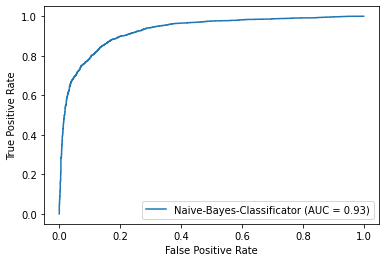

In [10]:
roc = metrics.plot_roc_curve(clf_naivebayes, df_test[["title", "text"]], df_test["label"],  name="Naive-Bayes-Classificator")

plt.show()

Auf den Test Daten zeigt Naive Bayes Klassifikator  mit einem AUC Wert von 0.93 eine gute Performanz.

### Literaturverzeichnis

(1): https://en.wikipedia.org/wiki/Bag-of-words_model

(2): https://pathmind.com/wiki/bagofwords-tf-idf

(3): https://de.wikipedia.org/wiki/Stemming

(4): https://towardsdatascience.com/stemming-lemmatization-what-ba782b7c0bd8

(5): https://de.wikipedia.org/wiki/ROC-Kurve

(6): https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/

(7): https://de.wikipedia.org/wiki/Transinformation

(8): https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html

(9): https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85

(10): http://optiv.de/methoden/KlassMet/KlassMet.pdf